### Libraries

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from scipy.stats import uniform, randint
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from xgboost import XGBRegressor


### Import and split datasets

In [20]:
df_Diamonds = pd.read_csv("../data/Diamonds_Price.csv")
df_Flight_price = pd.read_csv("../data/Flight_price.csv")[:10000]
df_Salary = pd.read_csv("../data/salary_prediction_data.csv")
df_Phone = pd.read_csv("../data/Cellphone.csv")

In [21]:
X_diamonds = df_Diamonds.drop(columns=["price"], axis=1)
Y_diamonds = df_Diamonds['price']

X_diamonds_train, X_diamonds_test, y_diamonds_train, y_diamonds_test = train_test_split(X_diamonds, Y_diamonds, test_size=0.3, random_state=42)

In [23]:
X_phone = df_Phone.drop(columns=["Price"], axis=1)
Y_phone = df_Phone['Price']

X_phone_train, X_phone_test, y_phone_train, y_phone_test = train_test_split(X_phone, Y_phone, test_size=0.3, random_state=42)

In [24]:
X_flight = df_Flight_price.drop(columns=["Unnamed: 0",'flight', "price"], axis=1)
Y_flight = df_Flight_price['price']

X_flight_train, X_flight_test, y_flight_train, y_flight_test = train_test_split(X_flight, Y_flight, test_size=0.3, random_state=42)

In [25]:
X_salary = df_Salary.drop(columns=["Salary"], axis=1)
Y_salary = df_Salary['Salary']

X_salary_train, X_salary_test, y_salary_train, y_salary_test = train_test_split(X_salary, Y_salary, test_size=0.3, random_state=42)

In [27]:
datasets = {
    "Phone": (X_phone, Y_phone),
    "Diamonds": (X_diamonds, Y_diamonds),
    "Salary": (X_salary, Y_salary),
    "Flight": (X_flight, Y_flight)
}

### Create Pipelines for preprocessing

In [15]:
si_cat=SimpleImputer(strategy="constant", fill_value='NO INFORMATION')
si_num = SimpleImputer(strategy='median')
scaler=MinMaxScaler()

numerical_pipeline = Pipeline(steps=[
    ('imputer', si_num),
    ('scaler', scaler)
    ])
    
category_pipeline = Pipeline(steps=[
    ('imputer', si_cat),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

col_transformer = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, make_column_selector(dtype_include=np.number)),
    ('cat', category_pipeline, make_column_selector(dtype_include='object'))
    ],
    remainder='drop',
    n_jobs=-1)  

### Final pipeline

In [16]:
RF_regressor = Pipeline([('preprocessor', col_transformer),
                            ('model', RandomForestRegressor())])
ElasticNet_regressor = Pipeline([('preprocessor', col_transformer),
                            ('model', ElasticNet())])    
XGB_regressor = Pipeline([('preprocessor', col_transformer),
                            ('model', XGBRegressor())])  

### Etap 1
Aby porównanie między zbiorami było miarodajne wszystkie zadania dotyczą regresji liniowej. Należy zauważyć, że standardowa metryka do walidacji wyników regresji czyli MSE nie będzie odpowiednia dla tego problemu. Zmienne objaśniające mają inny rozkład i skalę stąd nie można zakładać, że 100 MSE dla jednego zbioru jest takim samym sukcesem jak 100 dla drugiego. Z tego powodu do walidacji wyników został wybrany R^2, który jest już odpowiednio przeskalowany.

Wpier sprawdzony został R^2 dla wartośći domyslnych hiperparametrów dla każdego modelu

In [29]:
dict_r2_elastic = {}
dict_r2_xgb = {}
dict_r2_rf = {}

for name, (X, y) in datasets.items():
    r2_elastic = cross_val_score(ElasticNet_regressor, X, y, cv=5, scoring='r2')
    r2_xgb = cross_val_score(XGB_regressor, X, y, cv=5, scoring='r2')
    r2_rf = cross_val_score(RF_regressor, X, y, cv=5, scoring='r2')
    dict_r2_elastic[name] = r2_elastic
    dict_r2_xgb[name] = r2_xgb
    dict_r2_rf[name] = r2_rf
    print(f'Done for {name} dataset')

Done for Phone dataset
Done for Diamonds dataset
Done for Salary dataset
Done for Flight dataset


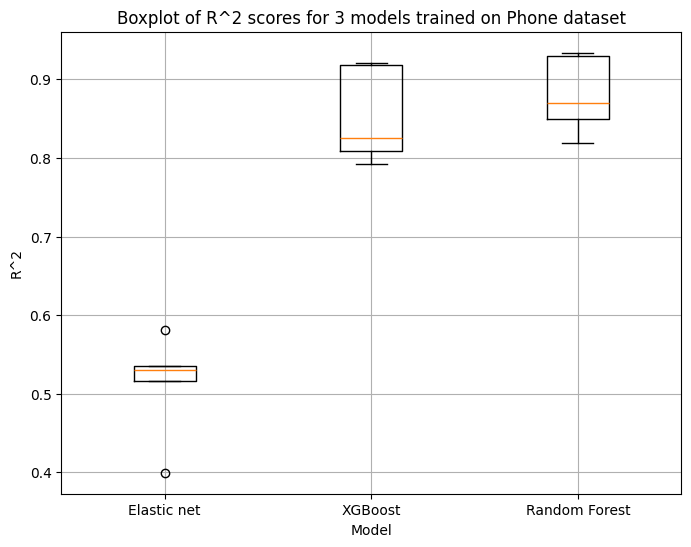

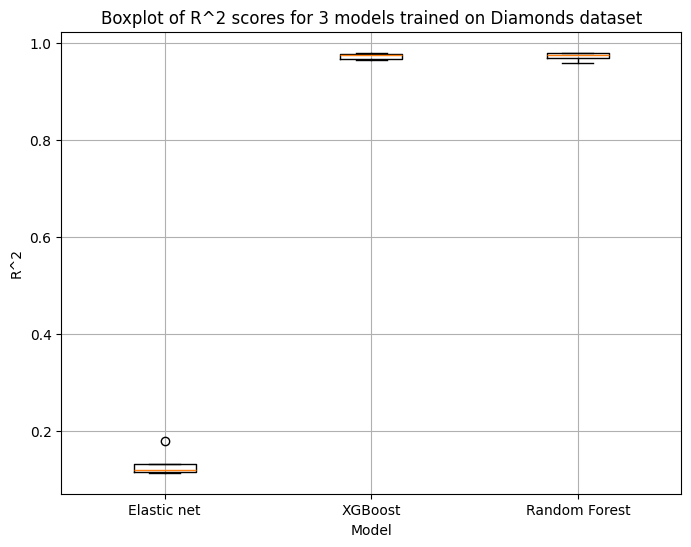

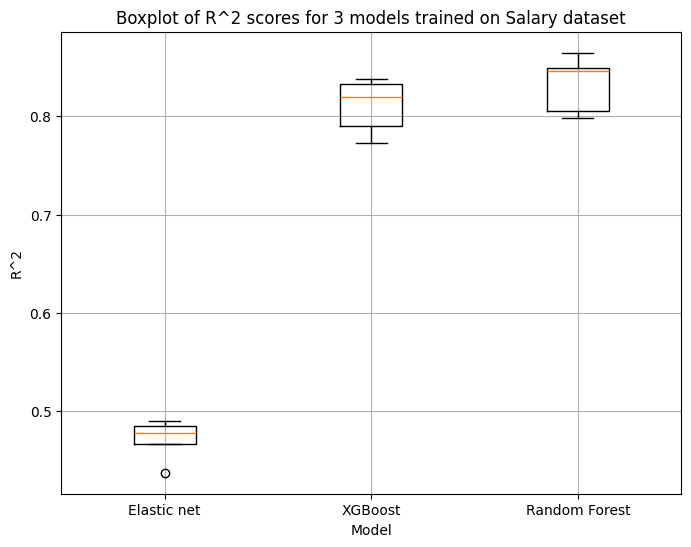

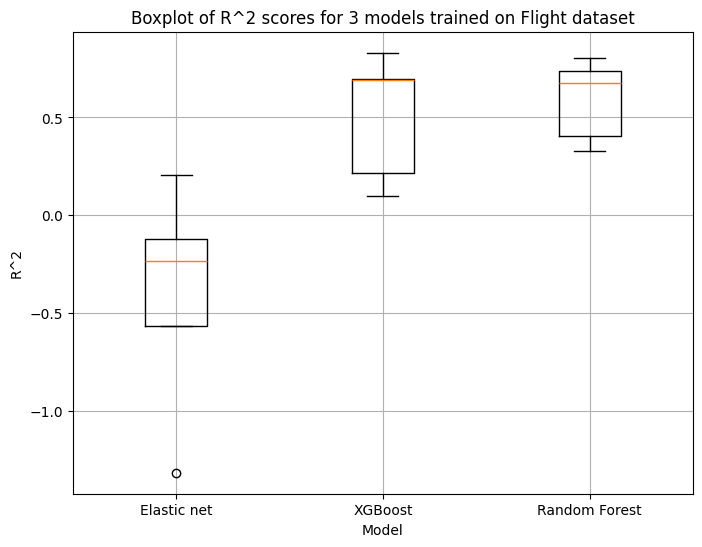

In [30]:
for name in datasets.keys():

    plt.figure(figsize=(8, 6))
    plt.boxplot([dict_r2_elastic[name], dict_r2_xgb[name], dict_r2_rf[name]], tick_labels=['Elastic net', 'XGBoost', 'Random Forest'])
    plt.title(f'Boxplot of R^2 scores for 3 models trained on {name} dataset')
    plt.ylabel('R^2') 
    plt.xlabel('Model')
    plt.grid(True)
    plt.savefig(f"{'../figures'}/box_plot_{name}.png", format="png")
    plt.show()

In [33]:
for name in datasets.keys():
    X ,Y = datasets[name]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    XGB_regressor.fit(X_train, y_train)
    y_pred = XGB_regressor.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"Współczynnik determinacji modelu XGB R^2 dla zbioru {name}:", r2)
    ElasticNet_regressor.fit(X_train, y_train)
    y_pred = ElasticNet_regressor.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"Współczynnik determinacji modelu enet R^2 dla zbioru {name}:", r2)
    RF_regressor.fit(X_train, y_train)
    y_pred = RF_regressor.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"Współczynnik determinacji modelu rf R^2 dla zbioru {name}:", r2)

Współczynnik determinacji modelu XGB R^2 dla zbioru Phone: 0.9799069166183472
Współczynnik determinacji modelu enet R^2 dla zbioru Phone: 0.5608868057941159
Współczynnik determinacji modelu rf R^2 dla zbioru Phone: 0.9624171183449868
Współczynnik determinacji modelu XGB R^2 dla zbioru Diamonds: 0.9728454947471619
Współczynnik determinacji modelu enet R^2 dla zbioru Diamonds: 0.11582177049548226
Współczynnik determinacji modelu rf R^2 dla zbioru Diamonds: 0.9739122455580896
Współczynnik determinacji modelu XGB R^2 dla zbioru Salary: 0.8252012513104301
Współczynnik determinacji modelu enet R^2 dla zbioru Salary: 0.4554527247880801
Współczynnik determinacji modelu rf R^2 dla zbioru Salary: 0.8463019490187148
Współczynnik determinacji modelu XGB R^2 dla zbioru Flight: 0.8451170921325684
Współczynnik determinacji modelu enet R^2 dla zbioru Flight: 0.22428602950973375
Współczynnik determinacji modelu rf R^2 dla zbioru Flight: 0.8403733479682467
